In [101]:
!pip install yfinance
import yfinance as yf
import pandas as pd
sp500 = yf.Ticker("^GSPC")
sp500 = sp500.history(period="max")
sp500.index = pd.to_datetime(sp500.index)

,Open,High,Low,Close,Volume
Date,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0
...,...,...,...,...,...
2024-03-27 00:00:00-04:00,5226.310059,5249.259766,5213.919922,5248.490234,3850500000
2024-03-28 00:00:00-04:00,5248.029785,5264.850098,5245.819824,5254.350098,3998270000
2024-04-01 00:00:00-04:00,5257.970215,5263.950195,5229.200195,5243.770020,3325930000


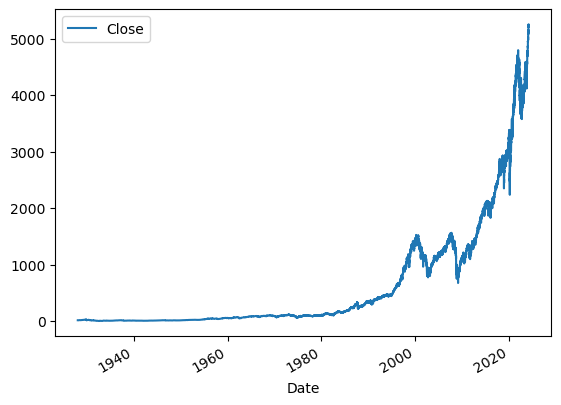

In [102]:
sp500.plot.line(y="Close" , use_index=True)
if "Dividends" in sp500.columns:
    del sp500['Dividends']
else:
    print("Column 'Dividends' does not exist in the DataFrame.")
if "Stock Splits" in sp500.columns:
    del sp500['Stock Splits']
else:
    print("Column 'Stock Splits' does not exist in the DataFrame.")
sp500

In [104]:
sp500["Tomorrow"] = sp500["Close"].shift(-1)
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)
sp500 = sp500.loc["1990-01-01":].copy()#Decided the old data was not going to be useful and would mess up the function. I chose 1990 because right before that year the stock fell due to inflation and I did not want to include that decline.

In [142]:
from sklearn.ensemble import RandomForestClassifier #Chose randomforest due to its fast running and non-linear output detection 
model= RandomForestClassifier(n_estimators=100, min_samples_split= 500, random_state= 1)

training = sp500.iloc[:-100]
testing = sp500.iloc[-100:]
predict1 = ["Close", "Volume", "Open", "High", "Low"]
model.fit(training[predictionst], training["Target"])

RandomForestClassifier(min_samples_split=500, random_state=1)

<Axes: xlabel='Date'>

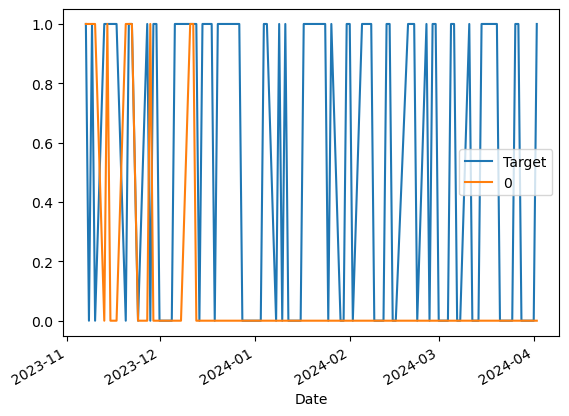

In [143]:
#Measuring How accurate the model is
from sklearn.metrics import precision_score
predic = model.predict(testing[predict1])
import pandas as pd
predic = pd.Series(predic, index=testing.index)

combine= pd.concat([testing["Target"],predic], axis=1)
combine.plot()

In [144]:
#Backtesting
def predict(training, testing, predict1, model):
    model.fit(training[predict1], training["Target"])
    predic = model.predict(testing[predict1])
    predic = pd.Series(predic, index=testing.index, name="Predictions")
    combine = pd.concat([testing["Target"], predic], axis=1)
    return combine 

def backtest(data, model, predict1, start=2500, step= 250):
    all_predictions = []
    for i in range(start , data.shape[0],step):
        training= data.iloc[0:i].copy()
        testing = data.iloc[i:(i+step)].copy()
        predictions = predict(training, testing, predict1, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)
predictions = backtest(sp500, model, predict1)

In [145]:
predictions["Predictions"].value_counts()#0 represents the days we predicted the market would go down and 1 is the times we predicted the market would go up.


Predictions
1    2901
0    2227
Name: count, dtype: int64

In [147]:
precision_score(predictions["Target"], predictions["Predictions"])# At 54% accuracy currently
predictions["Target"].value_counts()/predictions.shape[0]

Target
1    0.544462
0    0.455538
Name: count, dtype: float64

In [148]:
#Adding more predictors to improve accuracy
horizons = [2, 5, 60, 250, 1000]#Mean closing price in the last two days, week, three month, last year, and last four years. 
predict2 = []
#Looking at the sum of the target for the past few days
for l in horizons:
    averages = sp500.rolling(l).mean()
    ratio_column = f"Close_Ratio_{horizons}"
    sp500[ratio_column] = sp500 ["Close"] / averages["Close"]
    trends = f"Trend_{horizons}"
    sp500[trends] = sp500.shift(1).rolling(l).sum()["Target"]
    predict2 += [ratio_column, trends]

In [149]:
sp500 = sp500.dropna()
model = RandomForestClassifier(n_estimators=200, min_samples_split = 50, random_state = 1)
#Rewriting our original prediction function to improve our model
def predict(training, testing, predict1, model):
    model.fit(training[predict1], training["Target"])
    predic = model.predict_proba(testing[predict1])[:,1]
    predic[predic >= .6] = 1 
    predic[predic < .6] = 0
    predic = pd.Series(predic, index=testing.index, name="Predictions")
    combine = pd.concat([testing["Target"], predic], axis =1)
    return combine
predictions = backtest(sp500, model, predict2)

In [152]:
predictions["Predictions"].value_counts()

Predictions
0.0    2929
1.0    1199
Name: count, dtype: int64

In [153]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5246038365304421